In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import pinv

import mdpy as mdp

In [2]:
np.set_printoptions(precision=5, suppress=True)

# You-Only-Bump-Once

The MDP is structured like a hallway where you can either advance or return to the start.
Advancing at the end of the hallway yields a cumulant of 1, and also ends the episode.

In [13]:
# Solve using the matrix formulation
ns = 5
states = np.arange(ns)

I = np.eye(ns)

# transition matrix
p_forward = 0.5
p_backward = 1 - p_forward
P = np.diag(np.ones(ns-1)* p_forward, 1)
P[:ns-1,0] = p_backward
P[-1,-1] = 1

# expected reward matrix & vector
R = np.zeros((ns, ns))
R[-2][-1] = 1
rvec = np.sum(R*P, axis=1)

# gamma matrix
gm = np.ones(ns)*0.9
gm[-1] = 0
G = np.diag(gm)

In [7]:
P

array([[ 0.5,  0.5,  0. ,  0. ,  0. ],
       [ 0.5,  0. ,  0.5,  0. ,  0. ],
       [ 0.5,  0. ,  0. ,  0.5,  0. ],
       [ 0.5,  0. ,  0. ,  0. ,  0.5],
       [ 0. ,  0. ,  0. ,  0. ,  1. ]])

In [8]:
P @ G

array([[ 0.45,  0.45,  0.  ,  0.  ,  0.  ],
       [ 0.45,  0.  ,  0.45,  0.  ,  0.  ],
       [ 0.45,  0.  ,  0.  ,  0.45,  0.  ],
       [ 0.45,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [12]:
R * P

array([[ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0.5],
       [ 0. ,  0. ,  0. ,  0. ,  0. ]])

In [14]:
v = pinv(I - P @ G) @ rvec

In [15]:
v

array([ 0.21156,  0.25857,  0.36304,  0.5952 ,  0.     ])

In [16]:
v**2

array([ 0.04476,  0.06686,  0.1318 ,  0.35426,  0.     ])

Define

$$
v(s) = r(s) + \sum_{s'} p(s, s') \gamma(s') v(s')
$$

$$
F_{s} = \sum_{s'} p(s,s') (r(s,s') + \gamma v(s'))^2 - v^2(s)
$$

With the claim that the variance of the return is then

$$
\begin{align}
\operatorname{Var}\left[{G_t| S_t = s}\right] &= \sigma_s = F_s + \gamma^2 \sum_{s'} p(s,s') \sigma_s
\\\\
\vec{\sigma} &= \vec{F} + \gamma^2 P \vec{\sigma}
\\\\
\vec{\sigma} &= (I - \gamma^2 P)^{-1} \vec{F}
\end{align}
$$

In [17]:
v * gm

array([ 0.1904 ,  0.23271,  0.32674,  0.53568,  0.     ])

In [19]:
np.sum(P*(R + G@v)**2, axis=0)

array([ 0.0725 ,  0.02708,  0.05338,  0.14348,  0.5    ])

In [20]:
F = -(v**2).reshape(ns, 1)
for (i,j), p in np.ndenumerate(P):
    F[i] += P[i,j] * (R[i,j] + gm[j]*v[j])**2
    
sg = pinv(I - P @ G**2) @ F

In [21]:
F

array([[ 0.00045],
       [ 0.00465],
       [ 0.0298 ],
       [ 0.16386],
       [ 0.     ]])

In [18]:
# P*(R + G v)

In [22]:
tmp = np.zeros((ns, ns))
for (i,j), p in np.ndenumerate(P):
    tmp[i,j] = P[i,j]*(R[i,j] + gm[j]*v[j])**2
    
(np.sum(tmp, axis=1) - v**2).reshape(ns, 1)

array([[ 0.00045],
       [ 0.00465],
       [ 0.0298 ],
       [ 0.16386],
       [ 0.     ]])

In [24]:
# tmp

In [23]:
sg

array([[ 0.05362],
       [ 0.07767],
       [ 0.12668],
       [ 0.18558],
       [ 0.     ]])

In [24]:
np.linalg.cond((I - P @ G**2))

6.6250585573071827

In [63]:
num_episodes = 1000
num_steps = 1000

# Track returns for each trial for each state
ret_mat = np.zeros((num_episodes, ns))
viz_mat = np.zeros((num_episodes, ns))
fv_mat  = np.zeros((num_episodes, ns))

for i in range(num_episodes):
    # Run simulation
    s = 0
    step_lst = []
    for step in range(num_steps):
        sp = np.random.choice(states, p=P[s])
        reward = R[s, sp]
        step_lst.append([s, reward, sp])
        s = sp
        if sp == ns-1:
            break

    # Compute discounted return (every visit MC)
    ret = 0.0
    for (s, r, sp) in reversed(step_lst):
        ret += r
        
        # Update records
        ret_mat[i, s] += ret
        viz_mat[i, s] += 1
        
        # Prepare for next iteration
        ret *= gm[s]
        
    # Compute discounted return (first visit MC)
    
# Adjust for the fact that terminal state is visited once
viz_mat[:,-1] = 1

\begin{align}
G_t &= R_{t+1} + \gamma R_{t+2} + \ldots
\\
&= r(S_{t}, S_{t+1}) + \gamma r(S_{t+1}, S_{t+2}) + \ldots
\end{align}

In [64]:
ret_mat[:10]

array([[ 2.98263,  2.29308,  0.9    ,  1.     ,  0.     ],
       [ 0.729  ,  0.81   ,  0.9    ,  1.     ,  0.     ],
       [ 2.87638,  2.76673,  2.36657,  1.98469,  0.     ],
       [ 1.97559,  0.81   ,  0.9    ,  1.     ,  0.     ],
       [ 4.16485,  2.47964,  1.84847,  1.4555 ,  0.     ],
       [ 4.6847 ,  3.14461,  1.09621,  1.07179,  0.     ],
       [ 4.23927,  2.48544,  2.01614,  1.22873,  0.     ],
       [ 4.84315,  2.69712,  1.1816 ,  1.     ,  0.     ],
       [ 3.7384 ,  1.2883 ,  1.43144,  1.     ,  0.     ],
       [ 5.31743,  2.55478,  0.99249,  1.06461,  0.     ]])

In [65]:
viz_mat[:10]

array([[  6.,   4.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.],
       [ 35.,  21.,  11.,   4.,   1.],
       [  3.,   1.,   1.,   1.,   1.],
       [ 26.,  13.,   8.,   3.,   1.],
       [ 46.,  21.,   9.,   2.,   1.],
       [ 30.,  13.,   7.,   5.,   1.],
       [ 18.,  11.,   4.,   1.,   1.],
       [  8.,   2.,   2.,   1.,   1.],
       [ 31.,  11.,   3.,   2.,   1.]])

In [66]:
mc_mat = ret_mat/viz_mat

In [67]:
mc_mat[:10]

array([[ 0.4971 ,  0.57327,  0.9    ,  1.     ,  0.     ],
       [ 0.729  ,  0.81   ,  0.9    ,  1.     ,  0.     ],
       [ 0.08218,  0.13175,  0.21514,  0.49617,  0.     ],
       [ 0.65853,  0.81   ,  0.9    ,  1.     ,  0.     ],
       [ 0.16019,  0.19074,  0.23106,  0.48517,  0.     ],
       [ 0.10184,  0.14974,  0.1218 ,  0.53589,  0.     ],
       [ 0.14131,  0.19119,  0.28802,  0.24575,  0.     ],
       [ 0.26906,  0.24519,  0.2954 ,  1.     ,  0.     ],
       [ 0.4673 ,  0.64415,  0.71572,  1.     ,  0.     ],
       [ 0.17153,  0.23225,  0.33083,  0.53231,  0.     ]])

In [68]:
# Empirical mean
v_exp = np.mean(mc_mat, axis=0)

# Empirical variance
sg_exp = np.var(mc_mat, axis=0)

# Checking via expected mean
sg_check = np.mean(mc_mat**2, axis=0) - v**2

In [69]:
v_exp

array([ 0.36805,  0.43248,  0.55142,  0.76203,  0.     ])

In [70]:
v

array([ 0.21156,  0.25857,  0.36304,  0.5952 ,  0.     ])

In [71]:
sg

array([[ 0.05362],
       [ 0.07767],
       [ 0.12668],
       [ 0.18558],
       [ 0.     ]])

In [72]:
sg_exp

array([ 0.03964,  0.05188,  0.06881,  0.0724 ,  0.     ])

In [45]:
np.abs(sg_exp - sg.flat)/sg.flat

array([ 0.98187,  0.98154,  0.97877,  0.97124,  0.95704])

In [46]:
np.abs(sg_exp - sg.flat)/sg_exp.flat

array([ 54.15971,  53.16842,  46.10706,  33.77605,  22.27935])

Conversely, the empirical variance is substantially *lower* than what would be expected.

In [47]:
np.mean(mc_mat**2, axis=0) - np.mean(mc_mat, axis=0)**2

array([ 0.00031,  0.00045,  0.00085,  0.00175,  0.00059])

In [55]:
np.var(ret_mat**2/, axis=0)

array([ 960393.65913,  143906.61574,   43140.17153,   23447.11141,
         19333.70885])

In [48]:
mc_mat[:10]

array([[ 0.12098,  0.14648,  0.20835,  0.34169,  0.60303],
       [ 0.11937,  0.13807,  0.183  ,  0.31069,  0.58838],
       [ 0.12503,  0.1545 ,  0.22448,  0.39174,  0.62046],
       [ 0.11443,  0.14572,  0.20153,  0.34914,  0.59926],
       [ 0.11649,  0.15045,  0.20998,  0.36076,  0.6175 ],
       [ 0.09828,  0.12196,  0.17196,  0.28252,  0.58073],
       [ 0.13069,  0.17052,  0.22825,  0.37916,  0.65146],
       [ 0.09942,  0.12135,  0.1623 ,  0.2869 ,  0.59418],
       [ 0.12387,  0.14784,  0.22946,  0.34781,  0.60667],
       [ 0.11098,  0.13448,  0.1886 ,  0.29069,  0.59088]])

<Container object of 5 artists>

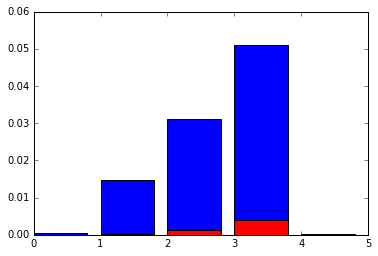

In [232]:
plt.bar(states, sg)
plt.bar(states, sg_exp, color='red')

<Container object of 5 artists>

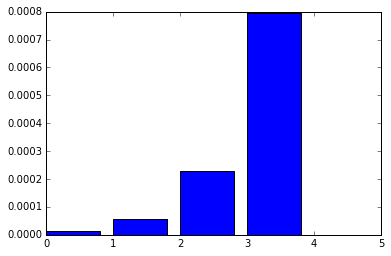

In [149]:
plt.bar(states, sg_exp)

In [145]:
v_exp

array([ 0.02052859,  0.04559857,  0.10127524,  0.22548427,  0.5       ])

In [146]:
v - v_exp

array([ -2.54605310e-05,  -3.60656976e-05,  -2.52444900e-05,
        -4.84273832e-04,   2.22044605e-16])